# EE4375: Extension of Fourth Lab Session: Revisit Assembly in Finite Element Method for the Poisson Equation on the Unit Interval

Here we further explore the assembly in the finite element method. We illustrate an approach that avoids static arrays. Our intention here is to compare the approach that uses static arrays with an approach that avoids static arrays.  

In [1]:
using LinearAlgebra 
using SparseArrays 

using BenchmarkTools
using Profile
using ProfileView

using Plots 

## Section 1: Introduction  

Fill in later. 

## Section 2: Refresher on Type-Stable Generation of Vectors
This section is intended as a reminder on how to construct vectors in a type-stable manner. 

### Section 1.2: Failing Versions 
We first show failing versions to reveal the art of getting to working versions. 

The version that follows uses a number of memory allocations proportional to problem size. Too many allocations are thus used. Not sure how to fix this except for using a double for-loop (see also below). 

In [2]:
function genvec1(N)
    #..allocate memory for the result.. 
    result = zeros(Float64,4*N)
    #..loop over entries.. 
    for i=1:N 
        result[4*i-3:4*i] .= (1.0*i*j for j=1:4)   
    end 
    return result 
end

genvec1 (generic function with 1 method)

In [3]:
@time genvec1(5);
@time genvec1(10);
@time genvec1(100);

  0.000007 seconds (6 allocations: 704 bytes)
  0.000002 seconds (11 allocations: 1.328 KiB)
  0.000004 seconds (101 allocations: 12.625 KiB)


### Section 2.2: A Working Version 
The version that follows uses a double for-loop. Not sure whether the inner loop can be avoided (see also above). 

In [4]:
function genvec2(N)
    result = zeros(Float64,4*N)
    for i=1:N 
        for j=1:4 
            result[4*(i-1)+j] = 1.0*i*j  
        end 
    end 
    return result 
end 

genvec2 (generic function with 1 method)

In [5]:
@time genvec2(5);
@time genvec2(10);
@time genvec2(100);

  0.000005 seconds (1 allocation: 224 bytes)
  0.000001 seconds (1 allocation: 400 bytes)
  0.000002 seconds (1 allocation: 3.250 KiB)


## Section 3: One-Dimensional Mesh Generation 

Exercise: extend from uniform to non-uniform mesh with local refinements to capture local variations in the solution (e.g. material interfaces, local features in the geometry, or large gradients near the boundary).  

In [6]:
# struct to hold a single mesh element
# all the members of the struct should be concrete type 
struct Element
  p1::Float64    # coordinate left-most node
  p2::Float64    # coordinate right-most node
  e1::Int64      # global index left-most node
  e2::Int64      # global index right-most node
  area::Float64  # area of the element 
end

# struct to hold entire mesh
struct Mesh
  nnodes::Int64
  nelements::Int64 
  Elements::Array{Element,1}
  Nodes::Vector{Float64}
  bndNodeIds::Vector{Int64}
  dofPerElem::Int64       
end 

In [9]:
# function to generate a mesh on the interval 0 <= x <= 1.   
# we limit the type of input to be Int64 
function genMesh(nelements::Int64)::Mesh
    h = 1/nelements 
    nnodes = nelements+1
    dofPerElem = 2 
    x = Vector{Float64}(0:h:1)    
    # what does the undef do here? 
    Elements = Array{Element,1}(undef,nelements)
    for i in 1:nelements
        Elements[i] = Element(x[i],x[i+1],i,i+1,x[i+1]-x[i])
    end
    mesh = Mesh(nnodes,nelements,Elements,x,[1,nelements+1],dofPerElem)     
    return mesh;
end 

genMesh (generic function with 1 method)

In [10]:
# test function for correctness of output 
mesh = genMesh(4)
typeof(mesh)

Mesh

## Section 4: Linear System Assembly 

### Section 1.4: Assemble Stiffness Matrix (free of static arrays)

Note that in the function generateMatrix!() given below performs in-place compuations (observe the use of ! - function with a bang). In this version the variables Iloc, Jloc, Aloc <b>do require</b> pre-allocation. Declaring these variables instead as static arrays is sufficient to obtain a type stable function.  

In [11]:
# generates local stiffness matrix 
function genLocStiffMat!(Iloc,Jloc,Aloc,element::Element)
    h     = element.area 
    e1    = element.e1
    e2    = element.e2
    Iloc  = (e1, e1, e2, e2) 
    Jloc  = (e1, e2, e1, e2) 
    Aloc  = (1/h, -1/h, -1/h, 1/h) 
    return Iloc, Jloc, Aloc
end

# generate global stiffness matrix 
function genStiffMat(mesh::Mesh)
    
    #..recover number of elements  
    nelements = mesh.nelements
    dofPerElem = mesh.dofPerElem; dofPerElem2 = dofPerElem^2;  
    
    #..preallocate the memory for global matrix 
    Avalues = zeros(Float64,dofPerElem2*nelements)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues))
    
    #..preallocate the memory for local matrix 
    Aloc = zeros(Float64,4)
    Iloc = zeros(Int64,4)
    Jloc = zeros(Int64,4)    

    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        Iloc, Jloc, Aloc = genLocStiffMat!(Iloc,Jloc,Aloc,element) 
        for j=1:dofPerElem2
            I[4*(i-1)+j] = Iloc[j] 
            J[4*(i-1)+j] = Jloc[j] 
            Avalues[4*(i-1)+j] = Aloc[j]     
        end 
    end
    
    A = sparse(I,J,Avalues)
       
    return A; 
end

genStiffMat (generic function with 1 method)

In [12]:
mesh = genMesh(10);
A = genStiffMat(mesh)
#@code_warntype generateMatrix(mesh)

11×11 SparseMatrixCSC{Float64, Int64} with 31 stored entries:
  10.0  -10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅ 
 -10.0   20.0  -10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅   -10.0   20.0  -10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅   -10.0   20.0  -10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅   -10.0   20.0  -10.0     ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅   -10.0   20.0  -10.0     ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   20.0  -10.0     ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   20.0  -10.0     ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   20.0  -10.0     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   20.0  -10.0
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   10.0

In [13]:
mesh = genMesh(10);    @time genStiffMat(mesh); # force function compilation 
mesh = genMesh(10);    @time genStiffMat(mesh); 
mesh = genMesh(100);   @time genStiffMat(mesh);
mesh = genMesh(1000);  @time genStiffMat(mesh); 
mesh = genMesh(10000); @time genStiffMat(mesh); 

  0.000013 seconds (16 allocations: 3.359 KiB)
  0.000009 seconds (16 allocations: 3.359 KiB)
  0.000015 seconds (16 allocations: 24.203 KiB)
  0.000046 seconds (23 allocations: 228.094 KiB)
  0.000548 seconds (26 allocations: 2.214 MiB)


### Section 2.4: Assemble Right-Hand Side Vector (again free of static arrays)

In [14]:
fsource(x) = x*(x-1)

function genLocVec!(Iloc,floc,element,sourceFct)
    h = element.area 
    e1    = element.e1
    e2    = element.e2
    Iloc  = (e1, e2)
    floc  = ((h/2)*sourceFct(element.p1), (h/2)*sourceFct(element.p2))
    return Iloc, floc
end

function genVec(mesh, sourceFct::F) where F 
    
    #..recover number of elements  
    nelements = mesh.nelements 
    nnodes = mesh.nnodes 
    dofperelem = 2;
    
    #..initialize global vector  
    f = zeros(Float64,nnodes)

    #..preallocate the memory for local vector 
    floc = zeros(Float64,2)
    Iloc = zeros(Int64,2)

    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        Iloc, floc = genLocVec!(Iloc,floc,element,sourceFct) 
        for j=1:dofperelem
            f[Iloc[j]] = floc[j] 
        end 
    end
   
    return f; 
end

genVec (generic function with 1 method)

In [15]:
# observe again how the number of memory allocations only depends midly on the mesh size
N=10;    mesh = genMesh(N); @time genVec(mesh,fsource); # force function compilation
N=10;    mesh = genMesh(N); @time genVec(mesh,fsource);
N=100;   mesh = genMesh(N); @time genVec(mesh,fsource);
N=1000;  mesh = genMesh(N); @time genVec(mesh,fsource);
N=10000; mesh = genMesh(N); @time genVec(mesh,fsource);

  0.013579 seconds (83.49 k allocations: 4.361 MiB, 99.83% compilation time)
  0.000003 seconds (3 allocations: 304 bytes)
  0.000002 seconds (3 allocations: 1.031 KiB)
  0.000004 seconds (3 allocations: 8.156 KiB)
  0.000015 seconds (4 allocations: 78.391 KiB)


## Section 5: Handle Essential Boundary Conditions 

In [16]:
function handleBoundaries!(A,f)
    #..handle essential boundary conditions 
    A[1,1] = 1.; A[1,2] = 0.; f[1] = 0.;
    A[end,end] = 1.; A[end,end-1] = 0.; f[end] = 0.;
    return A,f 
end 

handleBoundaries! (generic function with 1 method)

In [17]:
N=4; mesh = genMesh(4); A = genStiffMat(mesh); f = genVec(mesh,fsource); A,f = handleBoundaries!(A,f)
display(A)
display(f)

5×5 SparseMatrixCSC{Float64, Int64} with 13 stored entries:
  1.0   0.0    ⋅     ⋅     ⋅ 
 -4.0   8.0  -4.0    ⋅     ⋅ 
   ⋅   -4.0   8.0  -4.0    ⋅ 
   ⋅     ⋅   -4.0   8.0  -4.0
   ⋅     ⋅     ⋅    0.0   1.0

5-element Vector{Float64}:
  0.0
 -0.0234375
 -0.03125
 -0.0234375
  0.0

## Section 6: Solve Process 

In [18]:
function linSolve(A,f)
    u = A \ f 
    return u 
end

linSolve (generic function with 1 method)

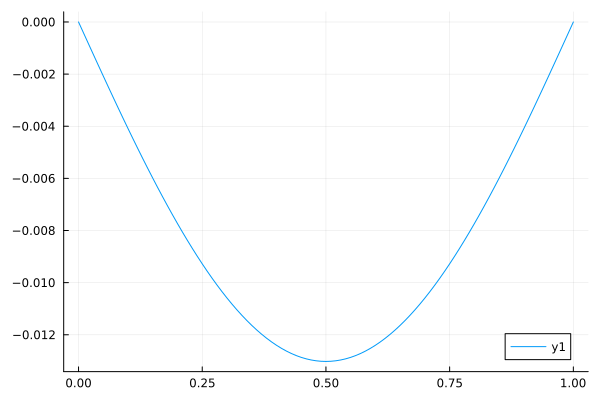

In [20]:
N=100; mesh = genMesh(N); 
A = genStiffMat(mesh); f = genVec(mesh,fsource); A,f = handleBoundaries!(A,f); 
u = linSolve(A,f)
plot(mesh.Nodes,u)

In [21]:
N=100; mesh = genMesh(N); 
A = genStiffMat(mesh); f = genVec(mesh,fsource); A,f = handleBoundaries!(A,f); 
@btime linSolve(A,f)
N=1000; mesh = genMesh(N); 
A = genStiffMat(mesh); f = genVec(mesh,fsource); A,f = handleBoundaries!(A,f); 
@btime linSolve(A,f)
N=10000; mesh = genMesh(N); 
A = genStiffMat(mesh); f = genVec(mesh,fsource); A,f = handleBoundaries!(A,f); 
@btime linSolve(A,f)

  36.791 μs (67 allocations: 124.55 KiB)
  342.666 μs (69 allocations: 1.06 MiB)
  3.606 ms (73 allocations: 10.45 MiB)


10001-element Vector{Float64}:
  0.0
 -4.166666625392205e-6
 -8.33333275083441e-6
 -1.2499997876476613e-5
 -1.6666661502568816e-5
 -2.0833323129461016e-5
 -2.4999982257603213e-5
 -2.9166638387545404e-5
 -3.33332910199376e-5
 -3.749993965552978e-5
 -4.166658379517196e-5
 -4.583322293981413e-5
 -4.999985659050631e-5
  ⋮
 -4.5833222932784917e-5
 -4.166658378878216e-5
 -3.749993964977941e-5
 -3.333329101482666e-5
 -2.9166638383073907e-5
 -2.4999982253771154e-5
 -2.0833323126263775e-5
 -1.666666150001102e-5
 -1.2499997874558264e-5
 -8.33333274955551e-6
 -4.166666624752754e-6
  0.0

## Sandbox